In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

################## LOGGING-BEGIN #########################
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
################## LOGGING-END ###########################

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py# Adapt 

HEIGHT_INDEX = 200 # Row index at which the crop begins
WIDTH_INDEX = 200  # Column index at which the crop begins

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS_IN = 3
NUM_CHANNELS_OUT = 2

TRAIN_FILES = 10
VAL_FILES = 2
TEST_FILES = 0
YEARS_PER_FILE = 10
IMGS_PER_YEAR = 365

TRAIN_MODE = 0
VAL_MODE = 1
TEST_MODE = 2

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    elevation_file = 'dem.pkl'
    
    train_list = np.array([
        '1950s.hdf5',
        '1960s.hdf5',
        '1970s.hdf5',
        '1980s.hdf5',
        '1990s.hdf5',
        '2000s.hdf5',
        '2010s.hdf5',
        '2020s.hdf5',
        '2030s.hdf5',
        '2040s.hdf5'
    ])
    
    val_list = np.array([
        '2050s.hdf5',
        '2060s.hdf5'
    ])

    test_list = np.array([
        
    ])

    def __init__(self, root, train=True):
        
        self.root = os.path.expanduser(root)
        self.train = train  # training set or test set
        
        # load elevation data
        fo_in = open(os.path.join(self.root, self.elevation_file), 'rb')
        self.elevation = pickle.load(fo_in)
        fo_in.close()
        elev_mean = np.mean(self.elevation)
        elev_var = np.var(self.elevation)
        self.elevation = (self.elevation - elev_mean) / np.sqrt(elev_var)
        h,w = self.elevation.shape
        self.elevation = self.elevation.reshape((1,h,w))

    in_mean = np.array([1.9028055e-05, 284.676482])
    in_var = np.array([1.5503707e-09, 108.102618])
    out_mean = np.array([1.902273e-05, 284.676482])
    out_var = np.array([2.3926674e-09, 108.102618])
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (low_res, high_res)
        """
#         t1 = time()
        file_idx = index // (YEARS_PER_FILE * IMGS_PER_YEAR)
        img_in_file = index % (YEARS_PER_FILE * IMGS_PER_YEAR)
        year_idx = img_in_file // IMGS_PER_YEAR
        idx_in_year = img_in_file % IMGS_PER_YEAR
        
        f = None
        if self.train == TRAIN_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.train_list[file_idx]), 'r')
        elif self.train == VAL_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.val_list[file_idx]), 'r')
        elif self.train == TEST_MODE:
            f = h5py.File(os.path.join(self.base_folder, self.test_list[file_idx]), 'r')
        
        yr = list(f.keys())[year_idx]
        pr =  f[yr]['pr'][idx_in_year]
        tas = f[yr]['tas'][idx_in_year]
        f.close()
        high_res = np.flip(np.concatenate((pr[np.newaxis,:,:], tas[np.newaxis,:,:])),axis=1)
        
        # Now crop the high_res as soon as we get it
        high_res = high_res[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # Also crop the elevation data to the same place
        elev_crop = self.elevation[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # get the input LR image from output HR image by blurring, cropping, then interpolating
        c,h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
        blurred = gaussian_filter(high_res, sigma = (0, 0.55, 0.55))
        half_res = blurred[:, ::2, ::2]
        # Code involved in interpolating the blurred image back up to high res resolution
        c,h2,w2 = half_res.shape
        x = np.arange(h2)
        y = np.arange(w2)
        xnew = np.arange(0, h2, h2/h1)
        ynew = np.arange(0, w2, w2/w1)
        low_res = np.zeros_like(high_res)
        for i in range(c):
            f = RectBivariateSpline(x, y, half_res[i, :, :])
            low_res[i, :, :] = f(xnew, ynew)
            
        # Normalize to mean 0, std 1 using precomputed statistics from the dataset
        low_res =  (low_res -  self.in_mean[:,np.newaxis,np.newaxis])  / np.sqrt(self.in_var[:,np.newaxis,np.newaxis])
        high_res = (high_res - self.out_mean[:,np.newaxis,np.newaxis]) / np.sqrt(self.out_var[:,np.newaxis,np.newaxis])
        
        # Add the elevation data to the input image
        low_res = np.concatenate((low_res, elev_crop))
        
        # Set the range of values of the training data from 0 to 1, and high res from -1 to 1, as they do in Ledig
        low_res -= np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_res /= np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        
        
        high_min = np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_max = np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        is_nan = np.int(high_min[0] == high_max[0] or high_min[1] == high_max[1])
        eps = 1e-9
        high_res = (high_res - high_min) / ((high_max - high_min + is_nan*eps) / 2) - 1
        
        
        if np.isnan(high_res).any():
            print("CREATED A NAN")
            print("high_min: ", high_min)
            print("high_max: ", high_max)
            print("year index: ", year_idx)
            print("idx in year: ", idx_in_year)
            print("pr contain nans? ", np.isnan(pr).any())
            print("tas contains nans? ", np.isnan(tas).any())
            
        
        # Gotta cast the lowres to float (from double) else it confuses the model, since model's standard
        # is to assume float
        low_res = torch.from_numpy(low_res).float() 
        high_res = torch.from_numpy(high_res).float()      
        
        #print(time()-t1)
        return low_res, high_res

    def __len__(self):
        if self.train:
            return len(self.train_in)
        else:
            return len(self.test_in)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [4]:
data_directory = '.'

batch_size = 200

sr_train = SR_Dataset(data_directory, train=TRAIN_MODE)
loader_train = DataLoader(sr_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

sr_val = SR_Dataset(data_directory, train=VAL_MODE)
loader_val = DataLoader(sr_val, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(VAL_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

#sr_val = SR_Dataset(data_directory, train=True, transform=transform, target_transform=transform)
#loader_val = DataLoader(sr_val, batch_size=batch_size, 
#                        sampler=sampler.SubsetRandomSampler(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE)))

#sr_test = SR_Dataset(data_directory, train=True, transform=transform)
#loader_test = DataLoader(sr_test, batch_size=batch_size)

In [5]:
# used https://github.com/togheppi/pytorch-super-resolution-model-collection/blob/master/srcnn.py to get basic idea
class SRCNN(nn.Module):
    def __init__(self, num_channels_in, num_channels_out, hidden_channels):
        super().__init__()
        
        self.layers = nn.Sequential( # this is the original SRCNN from Dong et al. 2015
            nn.ReplicationPad2d(4),
            #nn.Conv2d(num_channels_in, hidden_channels, 9, padding=4),
            nn.Conv2d(num_channels_in, hidden_channels, 9, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels//2, 1, padding=0),
            nn.ReLU(),
            nn.ReplicationPad2d(2),
            #nn.Conv2d(hidden_channels//2, num_channels_out, 5, padding=2)
            nn.Conv2d(hidden_channels//2, num_channels_out, 5, padding=0)
        )
        
    def forward(self, x):
        return self.layers(x)

In [6]:
def test_SRCNN():
    x = torch.zeros((64, NUM_CHANNELS_IN, IMG_HEIGHT, IMG_WIDTH), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = SRCNN(NUM_CHANNELS_IN, NUM_CHANNELS_OUT, 16)
    scores = model(x)
    print(scores.size())
test_SRCNN()

torch.Size([64, 2, 64, 64])


In [7]:
def plot_epoch(x, y_pred, y):
    plt.figure(figsize=(16,12))
    plt.subplot(2,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.subplot(2,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.subplot(2,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.subplot(2,3,4)
    plt.imshow(x[0,1,:,:].cpu().detach().numpy())
    plt.subplot(2,3,5)
    plt.imshow(y_pred[0,1,:,:].cpu().detach().numpy())
    plt.subplot(2,3,6)
    plt.imshow(y[0,1,:,:].cpu().detach().numpy())
    plt.show()

In [8]:
def plot_loss(train_loss, rmse_precip, rmse_temp):
    tcount = np.count_nonzero(train_loss)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(tcount), train_loss[range(tcount)])
    plt.title("SRCNN Loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(tcount), rmse_precip[range(tcount)])
    plt.plot(range(tcount), rmse_temp[range(tcount)])
    plt.legend(("Precipitation", "Temperature"))
    plt.title("SRCNN loss")
    plt.xlabel("Iteration")
    plt.show()

In [9]:
################## LOGGING-BEGIN #########################
# how often to log images
save_img_every = 500
val_every = 200
print_every = 200
exp_name = 'experiments/train_SRCNN_1e-4'
writer = SummaryWriter(exp_name)
################## LOGGING-END ###########################

In [10]:
def train_it(optimizer, model, num_epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print("Expected num iters: ", len(loader_train)*epochs)
    train_loss = np.zeros(len(loader_train)*num_epochs+1)
    rmse_precip = np.zeros(len(loader_train)*num_epochs+1)
    rmse_temp = np.zeros(len(loader_train)*num_epochs+1)
    iter_count = 0
    best_rmse_temp_val = 10000
    best_rmse_precip_val = 10000
    tic = time()
    for e in range(num_epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            train_loss[iter_count] = loss.item()
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            rmse_precip[iter_count] = torch.sqrt(torch.mean((y_predicted[:, 0, :, :] - y[:, 0, :, :]).pow(2)))
            rmse_temp[iter_count] = torch.sqrt(torch.mean((y_predicted[:, 1, :, :] - y[:, 1, :, :]).pow(2)))

            if iter_count % val_every == 0:
                loss_total = 0 
                rmse_precip_val, rmse_temp_val = check_accuracy(loader_val, model)
                if rmse_precip_val < best_rmse_precip_val:
                    torch.save(model.cpu().state_dict(), 'training_SRCNN_06_05_best_precip.pt')
                    model = model.to(device=device)
                    best_rmse_precip_val = rmse_precip_val
                    
                if rmse_temp_val < best_rmse_temp_val:
                    torch.save(model.cpu().state_dict(), 'training_SRCNN_06_05_best_temp.pt')
                    model = model.to(device=device)
                    best_rmse_temp_val = rmse_temp_val
                    
                writer.add_scalars('Both precip RMSE',
                                      {'Train': rmse_precip[iter_count],
                                      'Val': rmse_precip_val}, iter_count)
                writer.add_scalars('Both temp RMSE',
                                      {'Train': rmse_temp[iter_count],
                                      'Val': rmse_temp_val}, iter_count)
            writer.add_scalar('Precip RMSE Train', rmse_precip[iter_count], iter_count)
            writer.add_scalar('Temp RMSE Train', rmse_temp[iter_count], iter_count)
            
            if iter_count % print_every == 0:
                print('Epoch %d, Iteration %d, loss=%.4f, RMSEp=%.4f, RMSEt=%.4f' % (e, t, loss.item(), 
                                                                                     rmse_precip[iter_count], 
                                                                                     rmse_temp[iter_count]))
                plot_epoch(x, y_predicted, y)
                plot_loss(train_loss, rmse_precip, rmse_temp)
                
            if iter_count % save_img_every == 0:
                # precip
                input_precip_grid = vutils.make_grid(x[0, 0, :, :])
                writer.add_image('Input precipitation', input_precip_grid, iter_count)
                output_precip_grid = vutils.make_grid(y_predicted[0, 0, :, :])
                writer.add_image('Output precipitation', output_precip_grid, iter_count)
                true_precip_grid = vutils.make_grid(y[0, 0, :, :])
                writer.add_image('True precipitation', true_precip_grid, iter_count)
                # temp
                input_temp_grid = vutils.make_grid(x[0, 1, :, :])
                writer.add_image('Input temperature', input_temp_grid, iter_count)
                output_temp_grid = vutils.make_grid(y_predicted[0, 1, :, :])
                writer.add_image('Output temperature', output_temp_grid, iter_count)
                true_temp_grid = vutils.make_grid(y[0, 1, :, :])
                writer.add_image('True temperature', true_temp_grid, iter_count)
            
            iter_count += 1
                
            del x, y, loss
        torch.save(model.cpu().state_dict(), 'training_SRCNN_06_05_checkpoint.pt')
        model = model.to(device=device)
        print('Epoch ', e, ' complete!')

In [11]:
def check_baseline_accuracy(loader):
    #if loader.dataset.train == TRAIN_MODE:
    #    print('Checking accuracy on train set')
    #elif loader.dataset.train == VAL_MODE:
    #    print('Checking accuracy on validation set')
    #elif loader.dataset.train == TEST_MODE:
    #    print('Checking accuracy on test set')
    count, rmse_precip_x, rmse_temp_x = 0, 0, 0, 
    with torch.no_grad():
        for x, y in loader:
            y = y.to(device=device, dtype=dtype)
            
            # Normalize x to be in -1 to 1 for purpose of comparing with high res data in same range
            # Turn it into a numpy array
            x_np = x.numpy()
            x_min = np.amin(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            x_max = np.amax(x_np, axis=(2,3))[:, :, np.newaxis, np.newaxis]
            is_nan = np.int((x_min == x_max).any())
            eps = 1e-9
            x_norm_np = (x_np - x_min) / ((x_max - x_min + is_nan*eps) / 2) - 1
            
            x_norm = torch.from_numpy(x_norm_np)
            x_norm = x_norm.to(device=device, dtype=dtype)
            
            rmse_precip_x += torch.sqrt(torch.mean((x_norm[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_temp_x += torch.sqrt(torch.mean((x_norm[:,1,:,:]-y[:,1,:,:]).pow(2)))
            count += 1
            
        rmse_precip_x /= count
        rmse_temp_x /= count
        print('RMSEs: \tInput precip: %.3f\n\tInput temp: %.3f\n' % 
              (rmse_precip_x, rmse_temp_x))
        
    return rmse_precip_x, rmse_temp_x  

def check_accuracy(loader, model):
    model = model.to(device=device)
    model.eval() # set model to evaluation mode
    count, rmse_precip_ypred, rmse_precip_x, rmse_temp_ypred, rmse_temp_x = 0, 0, 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            y_predicted = model(x)
            rmse_precip_ypred += torch.sqrt(torch.mean((y_predicted[:,0,:,:]-y[:,0,:,:]).pow(2)))
            rmse_temp_ypred += torch.sqrt(torch.mean((y_predicted[:,1,:,:]-y[:,1,:,:]).pow(2)))
            count += 1
            
        rmse_precip_ypred /= count
        rmse_temp_ypred /= count
        #print('RMSEs: \tOutput precip: %.3f\n\tOutput temp: %.3f\n\t' % 
        #      (rmse_precip_ypred, rmse_temp_ypred))
    return rmse_precip_ypred, rmse_temp_ypred

RMSEs: 	Input precip: 0.143
	Input temp: 0.044

Expected num iters:  3660
Epoch 0, Iteration 0, loss=0.5060, RMSEp=0.9133, RMSEt=0.4218


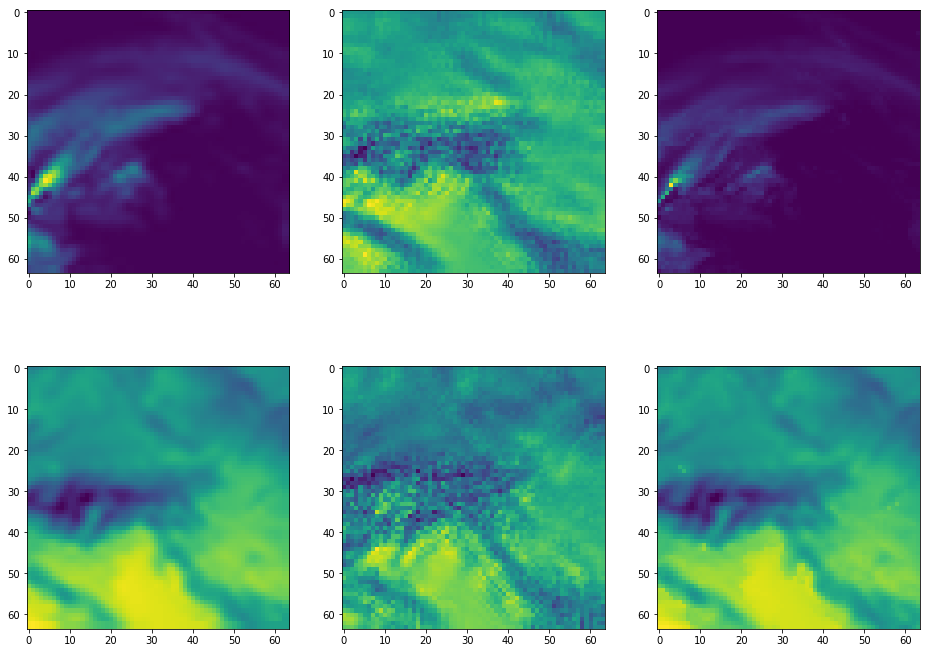

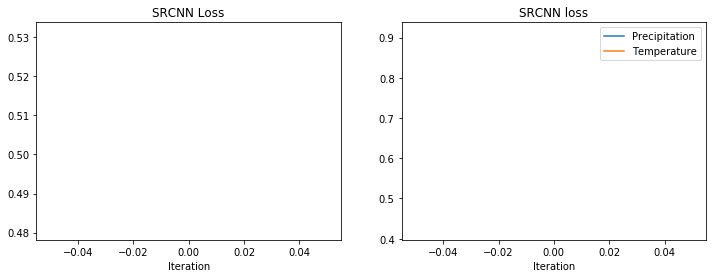

Epoch  0  complete!
Epoch 1, Iteration 17, loss=0.0186, RMSEp=0.1476, RMSEt=0.1241


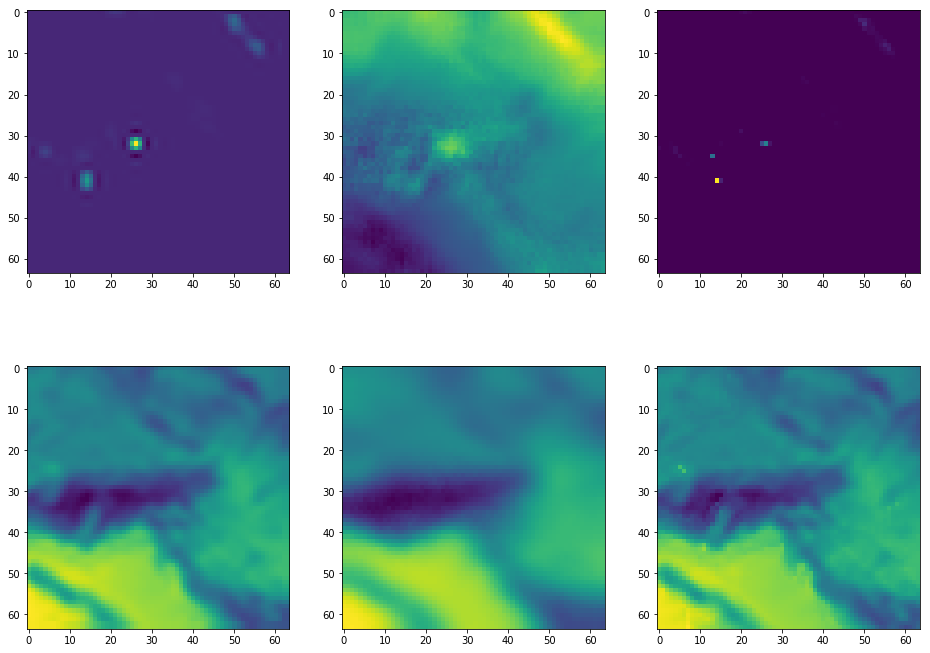

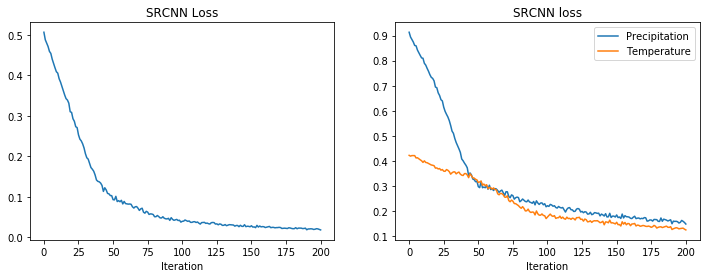

Epoch  1  complete!
Epoch 2, Iteration 34, loss=0.0077, RMSEp=0.1011, RMSEt=0.0722


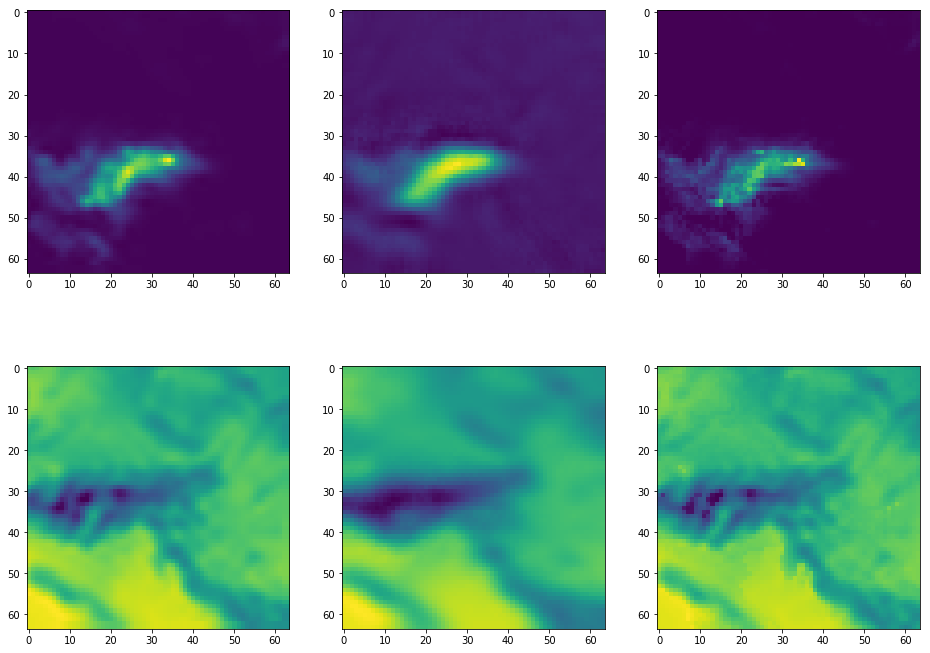

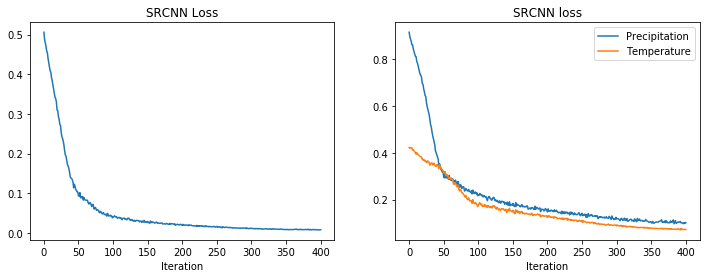

Epoch  2  complete!
Epoch 3, Iteration 51, loss=0.0076, RMSEp=0.1064, RMSEt=0.0617


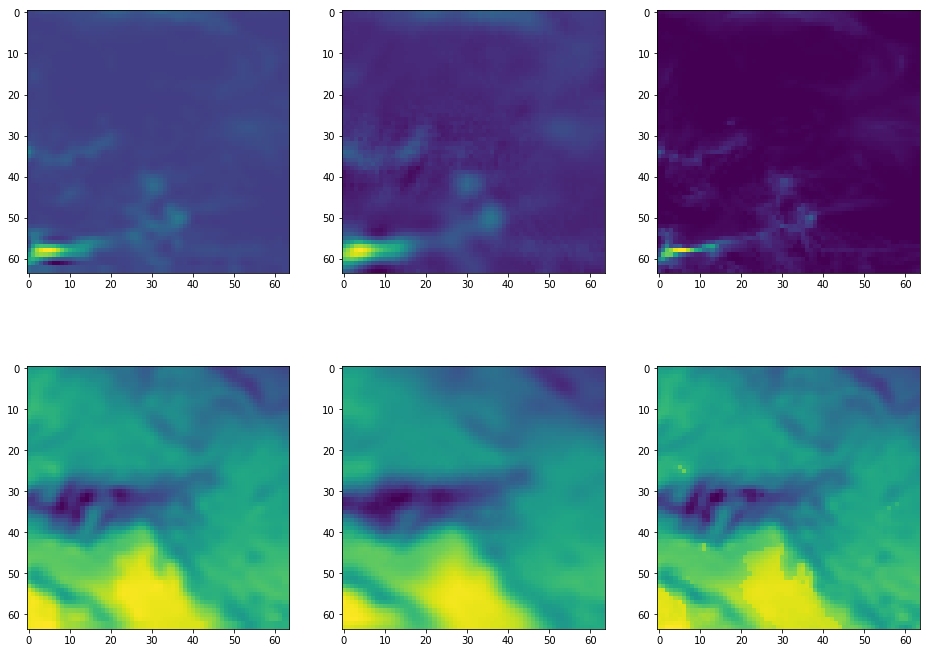

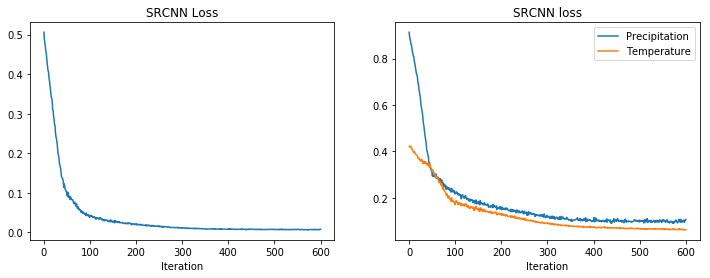

Epoch  3  complete!
Epoch 4, Iteration 68, loss=0.0062, RMSEp=0.0962, RMSEt=0.0564


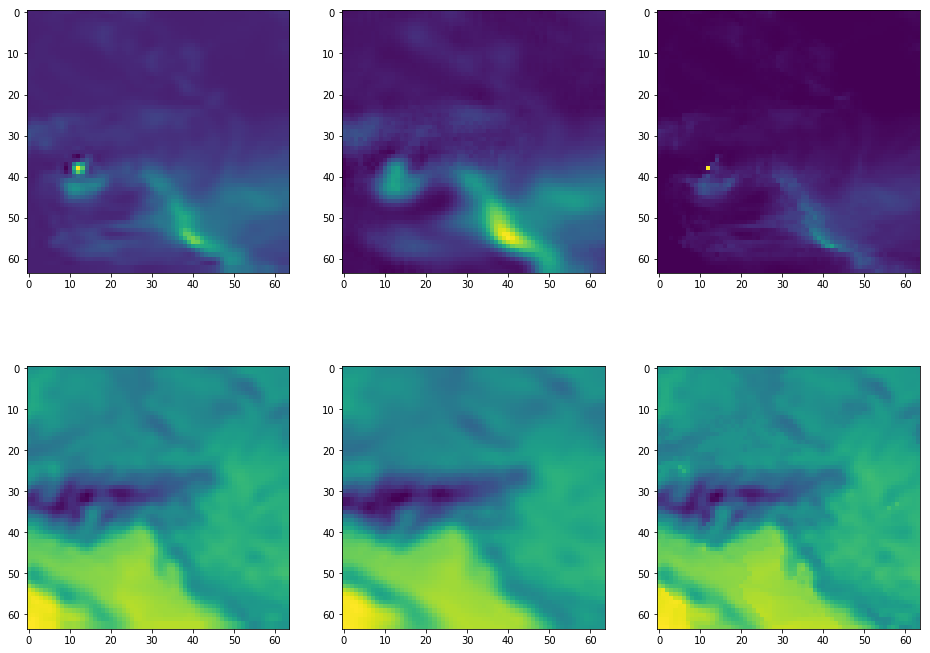

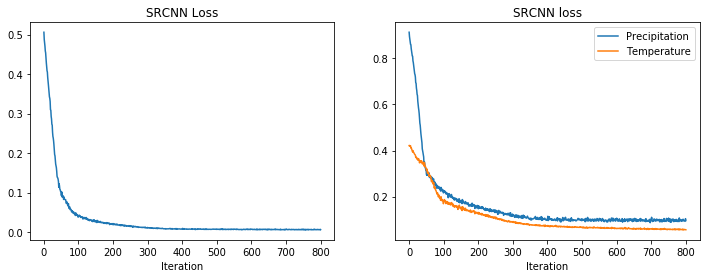

Epoch  4  complete!
Epoch 5, Iteration 85, loss=0.0062, RMSEp=0.0985, RMSEt=0.0528


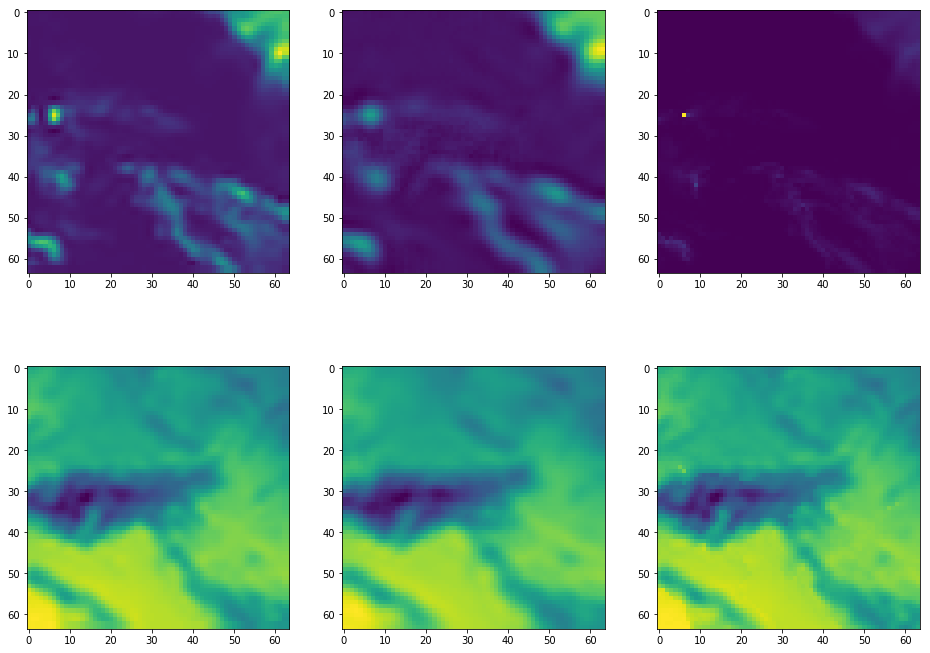

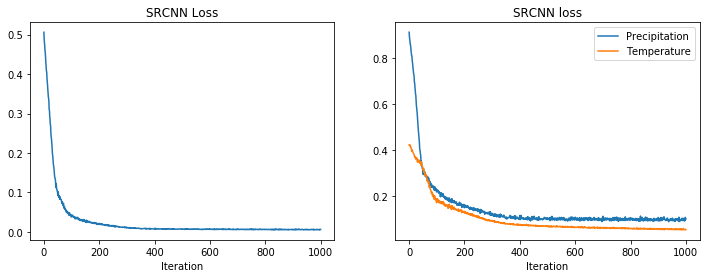

Epoch  5  complete!
Epoch 6, Iteration 102, loss=0.0059, RMSEp=0.0963, RMSEt=0.0504


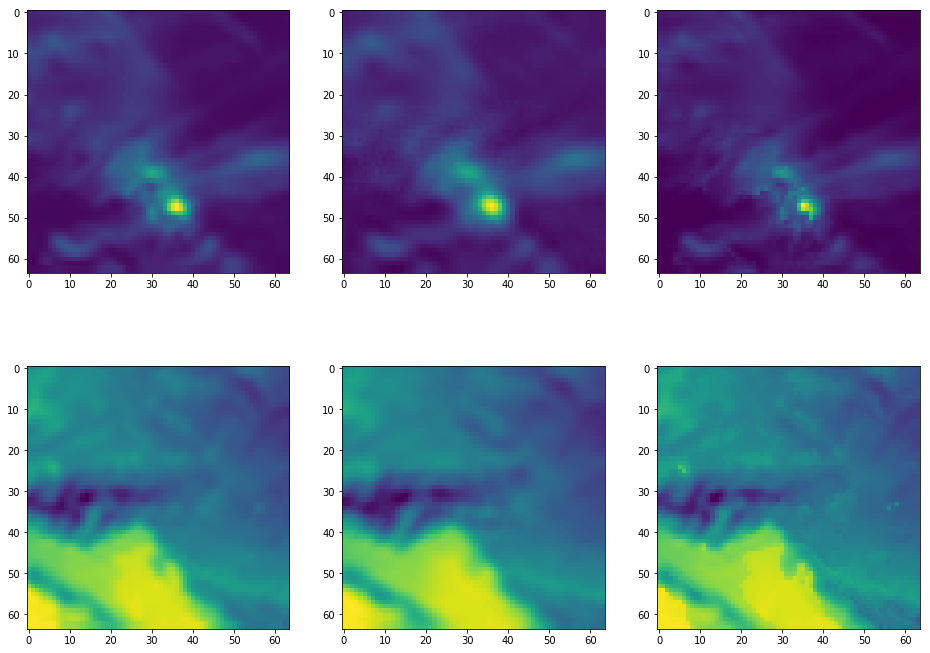

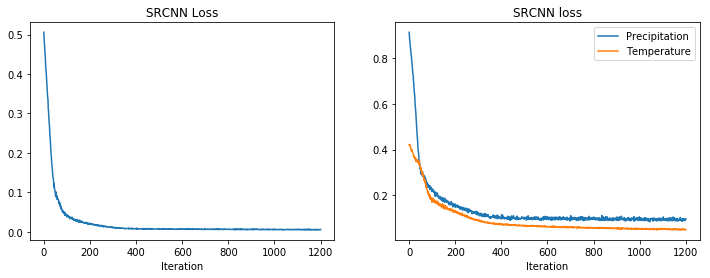

Epoch  6  complete!
Epoch 7, Iteration 119, loss=0.0056, RMSEp=0.0928, RMSEt=0.0504


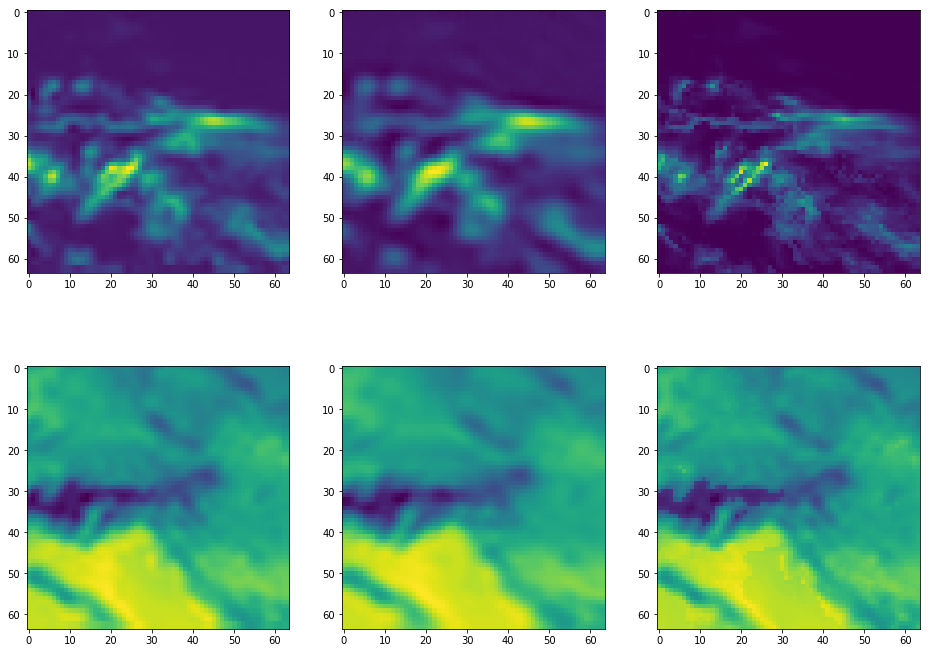

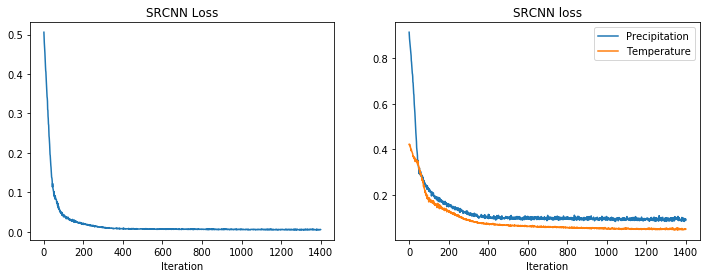

Epoch  7  complete!
Epoch 8, Iteration 136, loss=0.0058, RMSEp=0.0973, RMSEt=0.0463


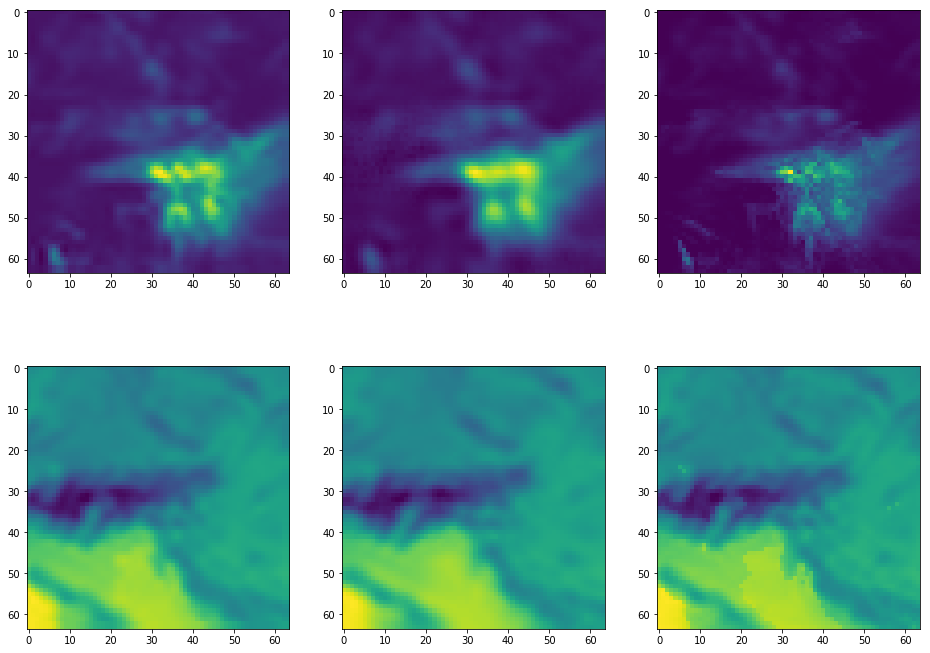

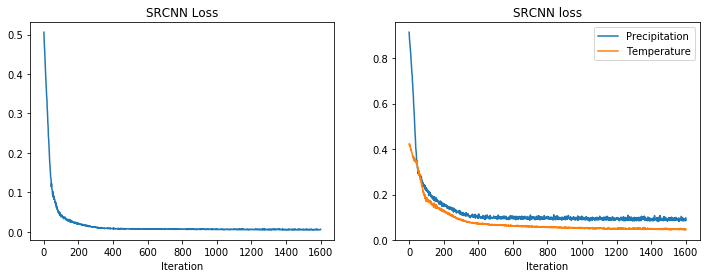

Epoch  8  complete!
Epoch 9, Iteration 153, loss=0.0053, RMSEp=0.0919, RMSEt=0.0472


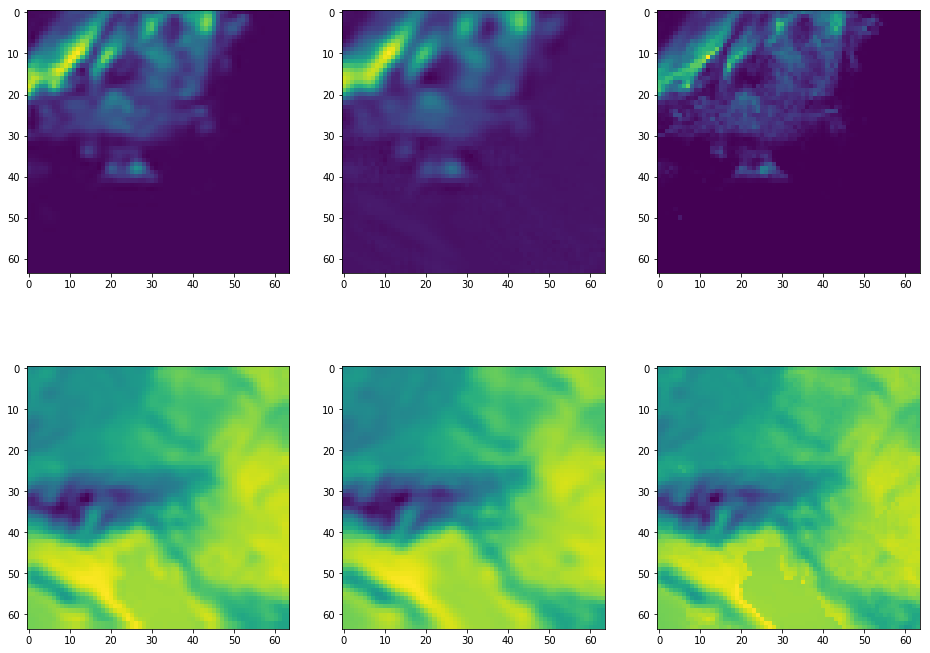

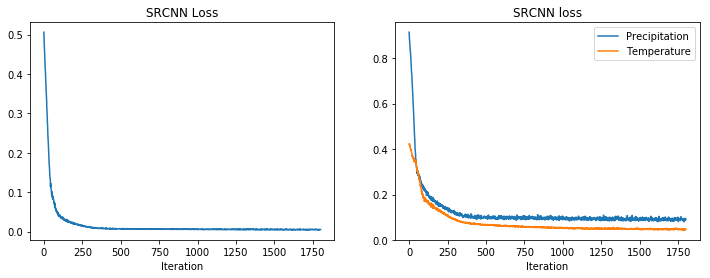

Epoch  9  complete!
Epoch 10, Iteration 170, loss=0.0050, RMSEp=0.0885, RMSEt=0.0457


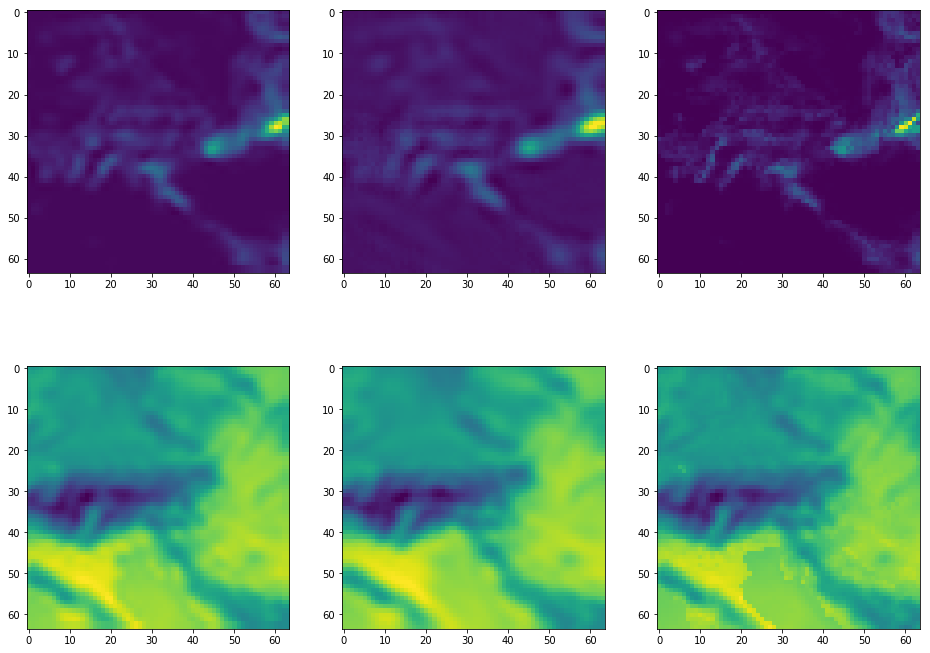

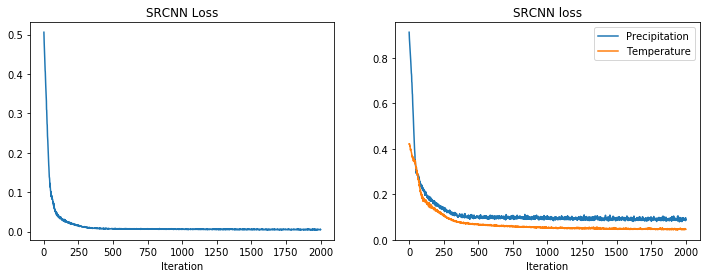

Epoch  10  complete!
Epoch  11  complete!
Epoch 12, Iteration 4, loss=0.0049, RMSEp=0.0877, RMSEt=0.0460


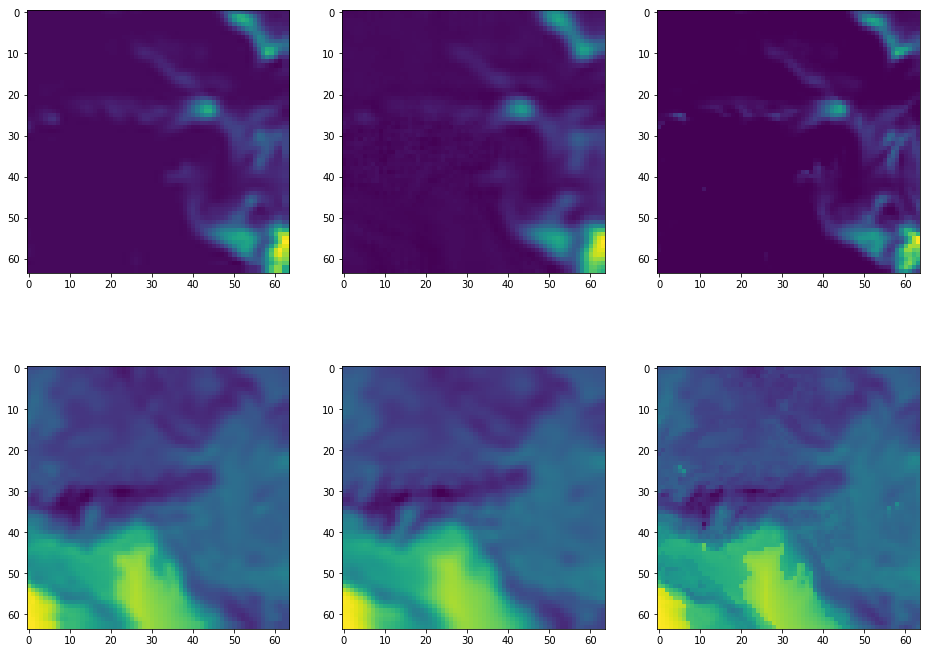

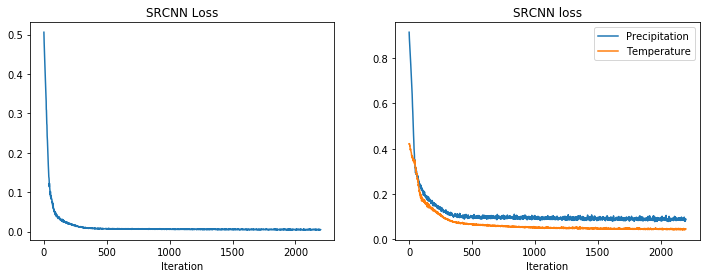

Epoch  12  complete!
Epoch 13, Iteration 21, loss=0.0042, RMSEp=0.0802, RMSEt=0.0439


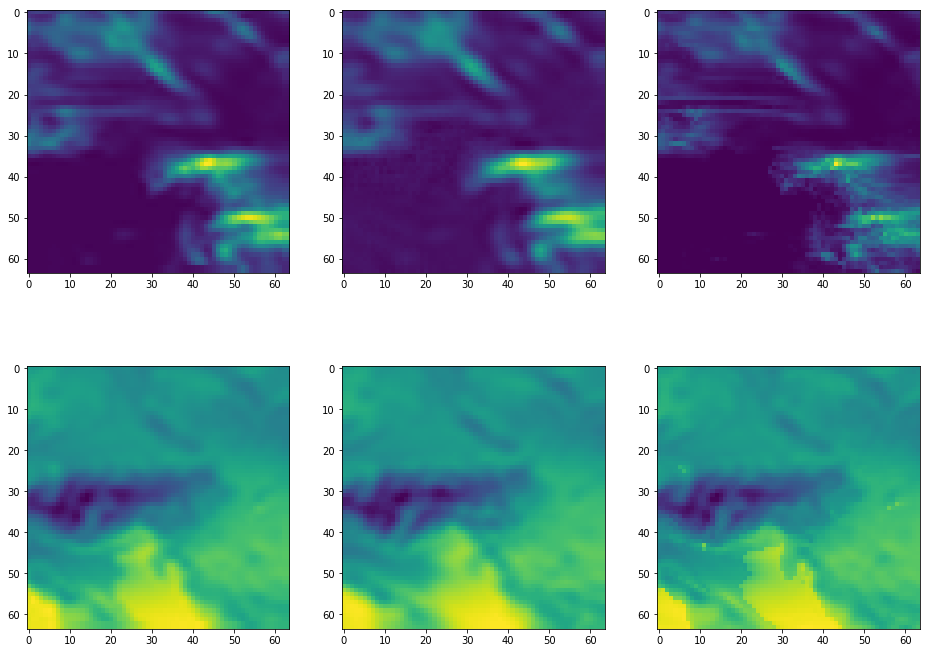

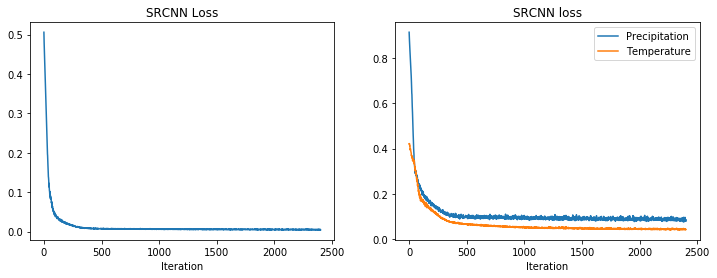

Epoch  13  complete!
Epoch 14, Iteration 38, loss=0.0051, RMSEp=0.0915, RMSEt=0.0429


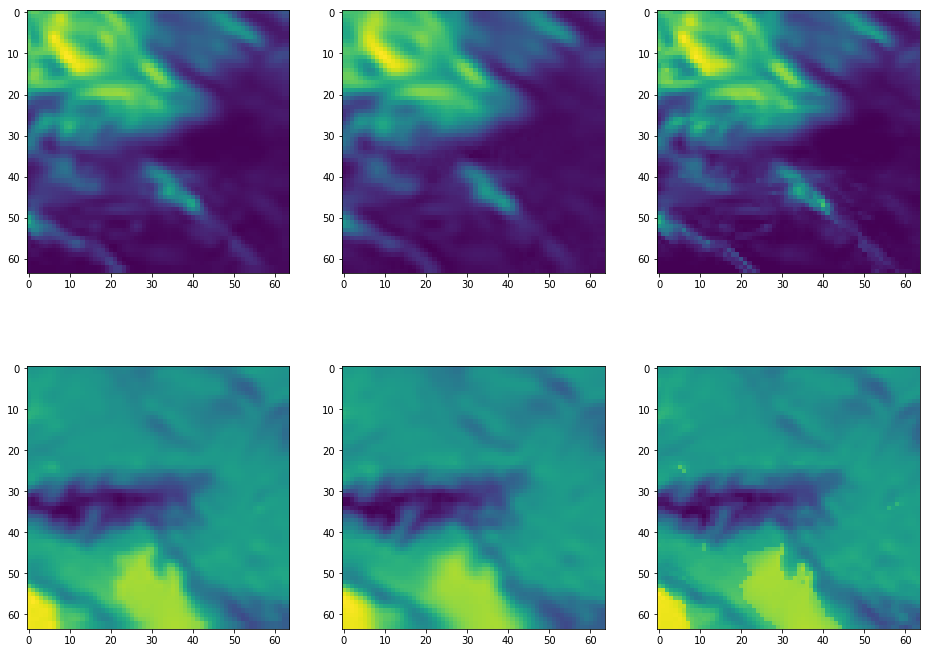

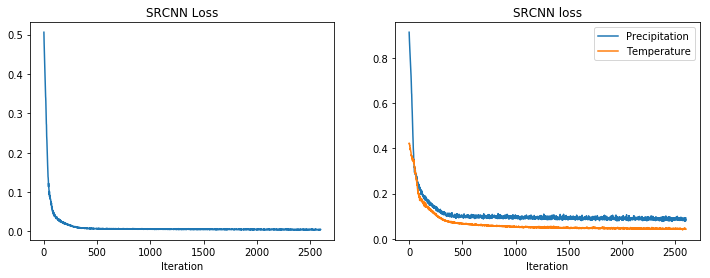

Epoch  14  complete!
Epoch 15, Iteration 55, loss=0.0043, RMSEp=0.0819, RMSEt=0.0427


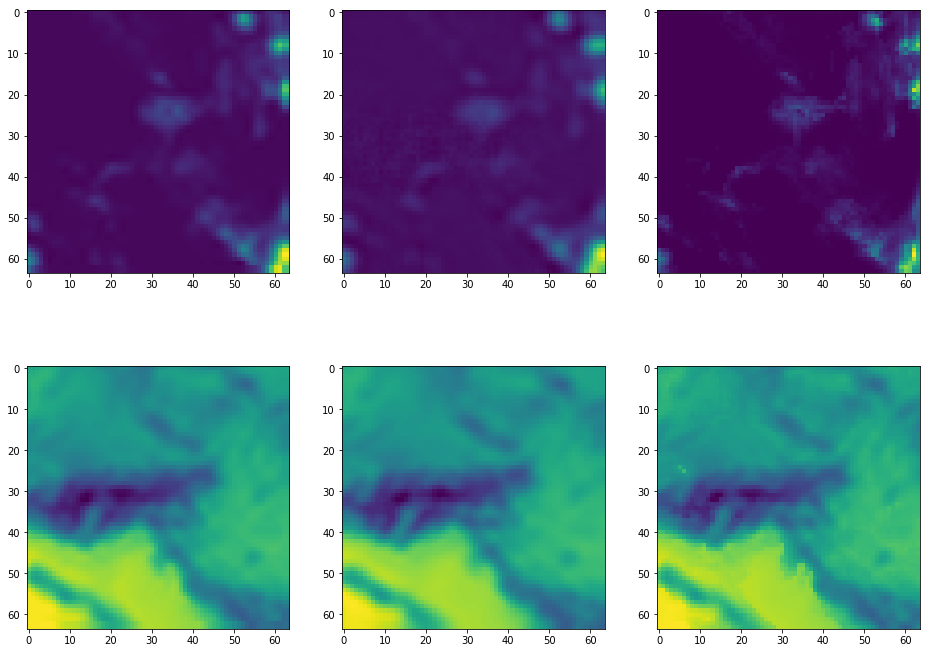

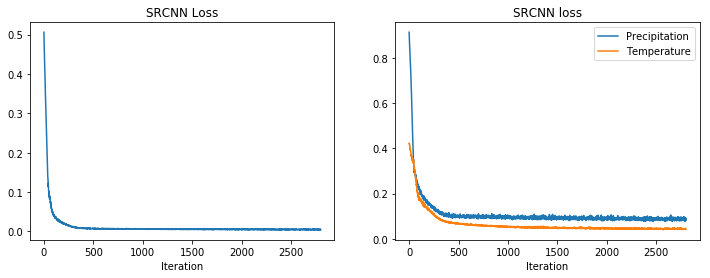

Process Process-122:
Process Process-121:
Process Process-123:
Process Process-124:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda

Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-b09b56f29fbc>", line 9, in <module>
    train_it(optimizer, model, num_epochs=epochs)
  File "<ipython-input-10-2cd07bd6cd7c>", line 12, in train_it
    for t, (x, y) in enumerate(loader_train):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/h

KeyboardInterrupt: 

In [12]:
learning_rate = 1e-4

epochs=20

check_baseline_accuracy(loader_val)
model = SRCNN(NUM_CHANNELS_IN, NUM_CHANNELS_OUT, 64)
#model.load_state_dict(torch.load('training_SRCNN_checkpoint_crop.pt'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_it(optimizer, model, num_epochs=epochs)